<a href="https://www.kaggle.com/code/potongpasir/cirrhosis?scriptVersionId=155022891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initial analysis
First, load in the data and see the columns and any NaN values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

c_train = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv")
c_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [2]:
c_train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
# copy out Y
c_train_y = c_train["Status"]
c_train = c_train.drop(columns="Status")

c_train_y.value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

In [4]:
c_train.isna().any()

id               False
N_Days           False
Drug             False
Age              False
Sex              False
Ascites          False
Hepatomegaly     False
Spiders          False
Edema            False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
Stage            False
dtype: bool

Luckily, NaN processing will not be needed.

# Data Processing
This is an interesting one-vs-all classification problem. To process this, we will:
1. One-hot encode the "Status" column
2. Remap the other categorical columns to numbers
3. Conduct analysis on the distribution of the continuous variables to see if we need to scale or normalise

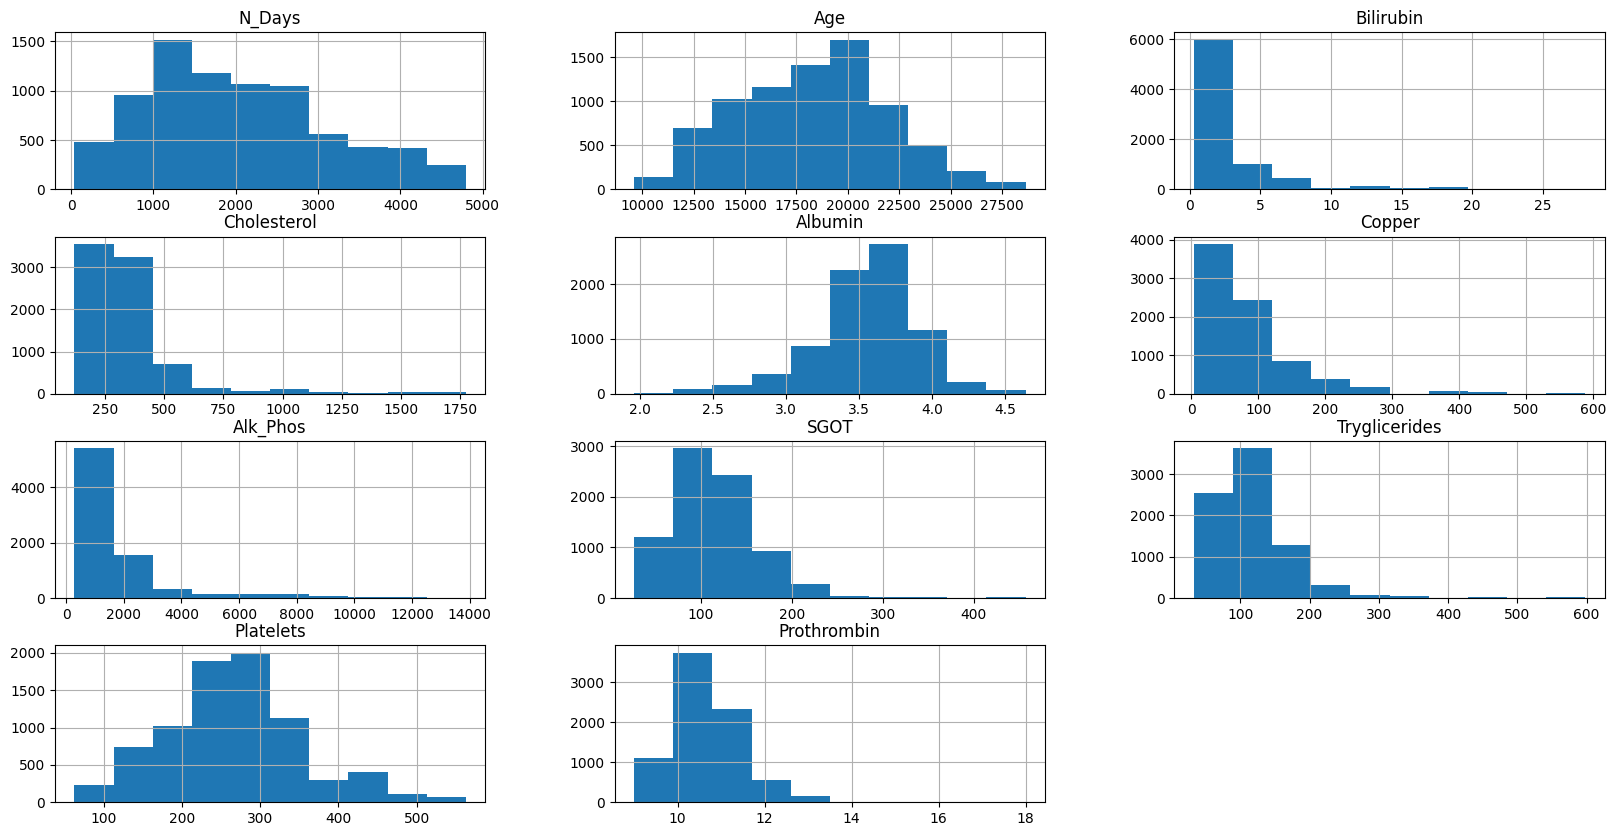

In [5]:
conts = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

c_train[conts].hist(figsize=(20, 10))
plt.show()

Almost all the columns have high magnitudes of value, thus we shall use StandardScaler to normalise the columns. In addition, we will use 

In [6]:
to_scale = ["Age", "N_Days", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Platelets", "Tryglicerides"]
left_skews = ["N_Days", "Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]
right_skews = ["Albumin"]

In [7]:
cats = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
for cat in cats:
    print(c_train[cat].value_counts())
    print("-"*30)

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64
------------------------------
Sex
F    7336
M     569
Name: count, dtype: int64
------------------------------
Ascites
N    7525
Y     380
Name: count, dtype: int64
------------------------------
Hepatomegaly
Y    4042
N    3863
Name: count, dtype: int64
------------------------------
Spiders
N    5966
Y    1939
Name: count, dtype: int64
------------------------------
Edema
N    7161
S     399
Y     345
Name: count, dtype: int64
------------------------------
Stage
3.0    3153
4.0    2703
2.0    1652
1.0     397
Name: count, dtype: int64
------------------------------


Notice that, besides the "Drug" and "Hepatomegaly" columns, almost all the columns have a predominant category. We shall not touch this.

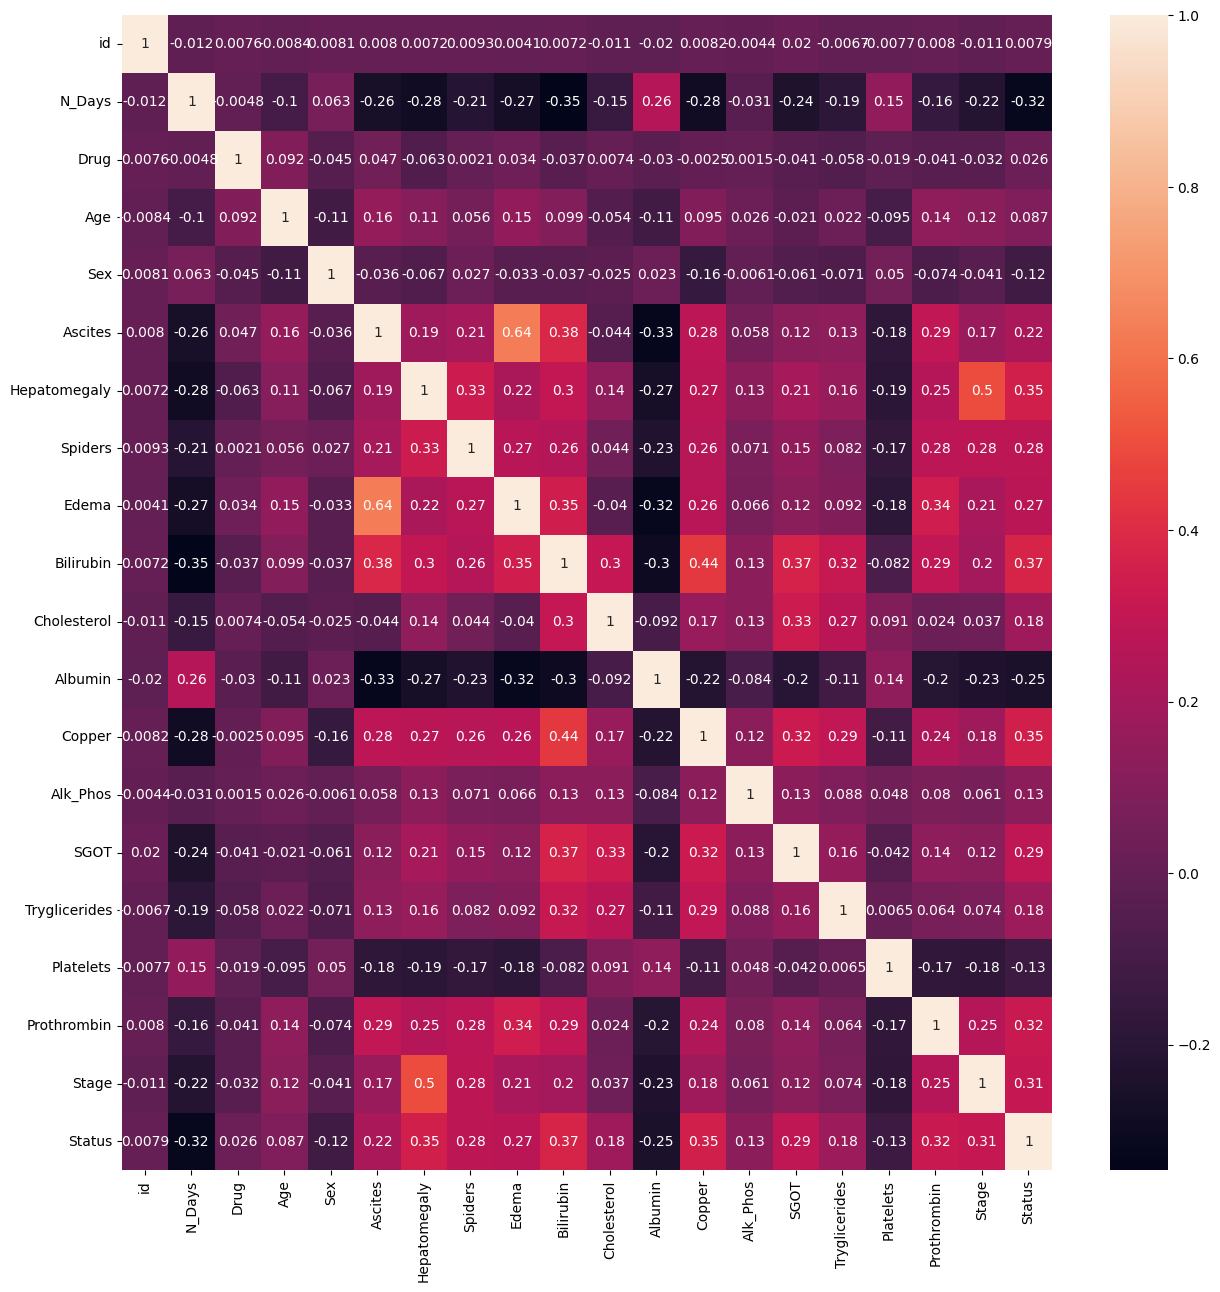

In [8]:
import seaborn as sns
c_train_corr = c_train.copy().replace({"Drug": {"Placebo": 0, "D-penicillamine": 1}, 
                    "Sex": {"M": 0, "F": 1},
                    "Edema": {"N": 0, "S": 1, "Y": 2},
                    "Ascites": {"N": 0, "Y": 1},
                    "Hepatomegaly": {"N": 0, "Y": 1},
                    "Spiders": {"N": 0, "Y": 1}})
c_train_corr = pd.concat([c_train_corr, c_train_y.replace({"C": 0, "D": 1, "CL": 2})], axis=1)
plt.figure(figsize=(15, 15))
sns.heatmap(c_train_corr.corr(), annot=True)
plt.show()

Viewing the correlation matrix, we can see several uncorrelated features like age, drug, sex, platelets and alk_phos. We can consider running models on two sets of data to see if the removal of these features helps with the prediction.

   N_Days  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
0     999     1  21532    0        0             0        0      0        2.3   
1    2574     0  19237    1        0             0        0      0        0.9   
2    3428     0  13727    1        0             1        1      2        3.3   
3    2576     0  18460    1        0             0        0      0        0.6   
4     788     0  16658    1        0             1        0      0        1.1   

   Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
0        316.0     3.35   172.0    1601.0  179.80           63.0      394.0   
1        364.0     3.54    63.0    1440.0  134.85           88.0      361.0   
2        299.0     3.55   131.0    1029.0  119.35           50.0      199.0   
3        256.0     3.50    58.0    1653.0   71.30           96.0      269.0   
4        346.0     3.65    63.0    1181.0  125.55           96.0      298.0   

   Prothrombin  Stage  
0          9.7

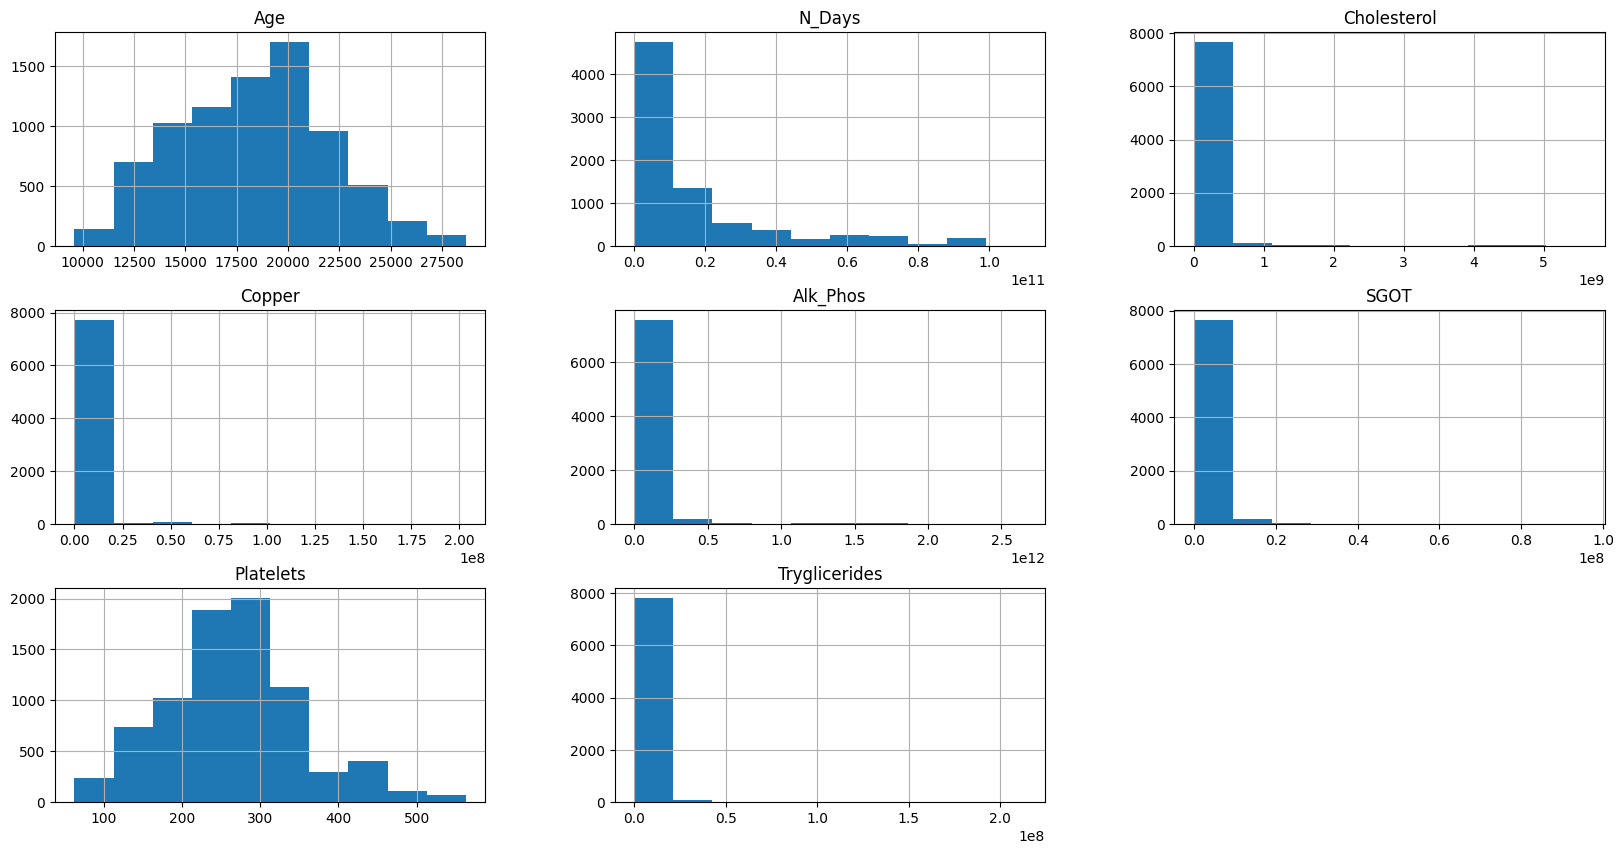

In [9]:
from sklearn.preprocessing import StandardScaler

def preprocess(c, cats, conts, left_skews, right_skews, scale="n", drop=False, correct_skew=False):
    # remap cats
    c = c.replace({"Drug": {"Placebo": 0, "D-penicillamine": 1}, 
                    "Sex": {"M": 0, "F": 1},
                    "Edema": {"N": 0, "S": 1, "Y": 2},
                    "Ascites": {"N": 0, "Y": 1},
                    "Hepatomegaly": {"N": 0, "Y": 1},
                    "Spiders": {"N": 0, "Y": 1}})
    
    # unskew
    if correct_skew:
        c[left_skews] = c[left_skews] ** 3
        c[right_skews] = c[right_skews] ** (1 / 3)
    
    # scale conts
    if scale == "y":
        s = StandardScaler()
        c[conts] = s.fit_transform(c[conts])
        c["Stage"] = c["Stage"].astype(int)
    
    # return id and c
    ids = c["id"]
    c = c.drop(columns="id")
    
    # drop columns (exploratory)
    if drop:
        c = c.drop(columns=["Age", "Drug", "Sex",])
    
    print(c.head())
    if correct_skew:
        c[conts].hist(figsize=(20, 10))
        plt.show()
    
    return ids, c.to_numpy()

c_master = c_train.copy()
_, c_train = preprocess(c_master, cats, to_scale, left_skews, right_skews)
_, c_train_unskewed = preprocess(c_master, cats, to_scale, left_skews, right_skews, correct_skew=True)

In [10]:
# lastly, split y
y = pd.get_dummies(c_train_y).astype(int).to_numpy()
print(y)

[[0 0 1]
 [1 0 0]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]


# Model Selection
Now, we run 

In [11]:
from sklearn.multiclass import OneVsRestClassifier as o
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBC
from catboost import CatBoostClassifier as CBC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV as gs

on = "on"
off= "off"

lr = o(LR(tol=1e-6, C=1.5, max_iter=400))
xgb = o(XGBC(n_estimators=350, eta=0.04, subsample=0.20, max_depth=7, booster="gbtree"))
cbc = o(CBC(iterations=350, eta=0.04, subsample=0.20, max_depth=7, verbose=False, loss_function="Logloss"))
vote = o(VotingClassifier(estimators=[("xgb", xgb), ("cbc", cbc)], voting="soft"))

models = {"lr": (off, lr), "xgb": (on, xgb), "cbc": (on, cbc), "vote": (on, vote)}
datasets = [("normal, skewed", c_train), ("normal, unskewed", c_train_unskewed)]
res = []

for name in models.keys():
    if models[name][0] == on:
        print(name)
        for n, data in datasets:
            scores = cross_val_score(models[name][1], data, y, scoring="neg_log_loss")
            print(f"{n}: {scores.mean()}")
            res.append((models[name][1], scores.mean()))
        print("-" * 30)

xgb
normal, skewed: -0.46373969530267917
normal, unskewed: -0.46373969530267917
------------------------------
cbc
normal, skewed: -0.4489639827871511
normal, unskewed: -0.44896375791548715
------------------------------
vote
normal, skewed: -0.4456511049428018
normal, unskewed: -0.44565098589574975
------------------------------


In [12]:
def choose(models):
    ms = sorted(models, key=lambda x: x[1], reverse=True)
    return ms[0][0]

model = choose(res)
model.fit(c_train, y)

OneVsRestClassifier(estimator=VotingClassifier(estimators=[('xgb',
                                                            OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                                                        booster='gbtree',
                                                                                                        callbacks=None,
                                                                                                        colsample_bylevel=None,
                                                                                                        colsample_bynode=None,
                                                                                                        colsample_bytree=None,
                                                                                                        device=None,
                                                                                                        early_stopping_rounds=None,
                                                                                                        enable_categorical=False,
                                                                                                        eta=0.04,
                                                                                                        eval_metric=None,
                                                                                                        feature_types=None,
                                                                                                        gamma=None,
                                                                                                        grow_...
                                                                                                        max_bin=None,
                                                                                                        max_cat_threshold=None,
                                                                                                        max_cat_to_onehot=None,
                                                                                                        max_delta_step=None,
                                                                                                        max_depth=7,
                                                                                                        max_leaves=None,
                                                                                                        min_child_weight=None,
                                                                                                        missing=nan,
                                                                                                        monotone_constraints=None,
                                                                                                        multi_strategy=None,
                                                                                                        n_estimators=350,
                                                                                                        n_jobs=None,
                                                                                                        num_parallel_tree=None, ...))),
                                                           ('cbc',
                                                            OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7dceb06d6bf0>))],
                                               voting='soft'))

# Prediction
Now we load in the test data, preprocess it, and predict

In [13]:
c_test = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv")

ids, c_test = preprocess(c_test, cats, to_scale, left_skews, right_skews)

   N_Days  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
0    3839     1  19724    1        0             1        0      0        1.2   
1    2468     1  14975    1        0             0        0      0        1.1   
2      51     0  13149    1        0             1        0      2        2.0   
3    2330     1  20510    1        0             0        0      0        0.6   
4    1615     1  21904    1        0             1        0      0        1.4   

   Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
0        546.0     3.37    65.0    1636.0  151.90           90.0      430.0   
1        660.0     4.22    94.0    1257.0  151.90          155.0      227.0   
2        151.0     2.96    46.0     961.0   69.75          101.0      213.0   
3        293.0     3.85    40.0     554.0  125.55           56.0      270.0   
4        277.0     2.97   121.0    1110.0  125.00          126.0      221.0   

   Prothrombin  Stage  
0         10.6

In [14]:
res = model.predict_proba(c_test)
res.shape

(5271, 3)

In [15]:
final = pd.DataFrame(res)
final = pd.concat([ids, final], axis=1)
final = final.set_index("id", drop=True)
final.columns = ["Status_C", "Status_CL", "Status_D"]
final.head()

,Status_C,Status_CL,Status_D
id,,,
7905,0.562423,0.014482,0.255102
7906,0.691531,0.108157,0.122716
7907,0.022685,0.021160,0.959151
7908,0.954791,0.003896,0.038179
7909,0.825885,0.071503,0.104646


In [16]:
final.to_csv("tee_boy.csv")